In [1]:
from keras.models import Sequential, clone_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, concatenate, Input
from scipy.stats import zscore
from matplotlib import pyplot
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
def Define_Model():
    
    model_input = Input(shape=(19,1,50))
    x = Conv2D(20, (1, 3), activation='relu', kernel_initializer='glorot_uniform', data_format='channels_first')(model_input)
    x = MaxPooling2D((1, 2), data_format='channels_first')(x)
    x = Conv2D(40, (1, 3), activation='tanh', kernel_initializer='glorot_uniform', data_format='channels_first')(x)
    x = MaxPooling2D((1, 2), data_format='channels_first')(x)
    x = Conv2D(60, (1, 3), activation='relu', kernel_initializer='glorot_uniform', data_format='channels_first')(x)
    
    max_pool_output = MaxPooling2D((1, 3), data_format='channels_first')(x)
    conv_output = Conv2D(80, (1, 3), activation='tanh', kernel_initializer='glorot_uniform', data_format='channels_first')(max_pool_output)
    
    max_pool_output_flattened = Flatten(data_format='channels_first')(max_pool_output)
    conv_output_flattened = Flatten(data_format='channels_first')(conv_output)
    
    combined_layer = concatenate([max_pool_output_flattened, conv_output_flattened])
    
    deep_mf = Dense(100, activation='relu')(combined_layer)
    out = Dense(4, activation='softmax')(deep_mf)
    
    model = Model(inputs=model_input, outputs=out)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    #print(model.summary())
    return model  

In [3]:
def read_and_reshape_data(filename):
    df = pd.read_csv(filename)
    df = df.drop(df.columns[[0]], axis=1)
    df_num = df.select_dtypes(include=[np.float64])
    df_normalized = df_num.apply(zscore)
    df[df_normalized.columns] = df_normalized
    np_df = df.to_numpy()
    reshaped_df = np.reshape(np_df, (50, 140, 23))
    return reshaped_df

In [4]:
def get_training_and_testing_data(a, axis):
    b = np.swapaxes(a, 0, 1)
    np.random.shuffle(b)
    shuffled_data = np.swapaxes(b, 0, 1)
    training_data = np.take(shuffled_data, np.arange(200), axis=1)
    testing_data = np.take(shuffled_data, np.arange(200,560), axis=1)
    return training_data, testing_data    

In [5]:
def get_input_and_labels(data,size):
    input_df = data[:,:,0:19]
    input_df = np.expand_dims(input_df, axis=3)
    input_df = np.moveaxis(input_df, 0, 3)

    labels = data[:,:,19:23]
    labels_squeezed = labels[1,:,:].reshape(size,4)
    
    return input_df, labels_squeezed

In [6]:
def result_show(history):
    #plot the loss graph
    pyplot.subplot(211)
    pyplot.title('cross entropy loss')
    pyplot.plot(history.history['loss'],color ='blue',label = 'training')
    pyplot.plot(history.history['val_loss'],color ='orange',label ='testing')
    #plot accuracy graph
    pyplot.subplot(212)
    pyplot.title('accuracy')
    pyplot.plot(history.history['accuracy'],color ='blue',label = 'training')
    pyplot.plot(history.history['val_accuracy'],color ='orange',label ='testing')

In [18]:
def run_test(training_data, testing_data):
    model = Define_Model();
    training_input, training_output = get_input_and_labels(training_data, 200)
    testing_input, testing_output = get_input_and_labels(testing_data, 360)
    
    mod = model.fit(training_input, training_output,  batch_size=5, epochs=15, validation_split=0.5)
    loss, metrics = model.evaluate(testing_input, testing_output, batch_size=5)
    
    print('------> %.3f' % (metrics * 100.0))
    result_show(mod)
    

In [19]:
reshaped_rf = read_and_reshape_data('rf.csv')
reshaped_rb = read_and_reshape_data('rb.csv')
reshaped_lf = read_and_reshape_data('lf.csv')
reshaped_lb = read_and_reshape_data('lb.csv')

In [20]:
combined_data = np.concatenate([reshaped_rf, reshaped_rb, reshaped_lf, reshaped_lb], axis=1)

In [21]:
training_data, testing_data = get_training_and_testing_data(combined_data, 1)

Train on 100 samples, validate on 100 samples
Epoch 1/15
100/100 [==============================] - 0s 4ms/step - loss: 1.1039 - accuracy: 0.6800 - val_loss: 0.7153 - val_accuracy: 1.0000
Epoch 2/15
100/100 [==============================] - 0s 1ms/step - loss: 0.5289 - accuracy: 1.0000 - val_loss: 0.3378 - val_accuracy: 1.0000
Epoch 3/15
100/100 [==============================] - 0s 1ms/step - loss: 0.2457 - accuracy: 1.0000 - val_loss: 0.1844 - val_accuracy: 1.0000
Epoch 4/15
100/100 [==============================] - 0s 1ms/step - loss: 0.1374 - accuracy: 1.0000 - val_loss: 0.1153 - val_accuracy: 1.0000
Epoch 5/15
100/100 [==============================] - 0s 2ms/step - loss: 0.0878 - accuracy: 1.0000 - val_loss: 0.0769 - val_accuracy: 1.0000
Epoch 6/15
100/100 [==============================] - 0s 1ms/step - loss: 0.0611 - accuracy: 1.0000 - val_loss: 0.0578 - val_accuracy: 1.0000
Epoch 7/15
100/100 [==============================] - 0s 1ms/step - loss: 0.0459 - accuracy: 1.0000 - 

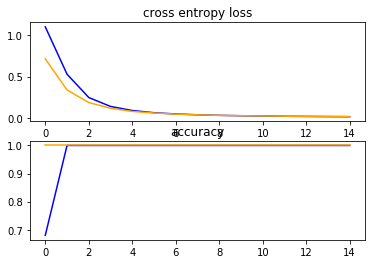

In [22]:
run_test(training_data, testing_data)